In [1]:
import os
import zipfile
import fnmatch
import pandas as pd
import dotenv
from multiprocessing import Pool, cpu_count
from functools import partial

dotenv.load_dotenv()

True

### Load Raw Data

In [ ]:
DATA_FOLDER=os.getenv("DATA_FOLDER")

In [ ]:
def extract_prefix_from_name(inner_name):
    marker = "_FLUXNET_FULLSET_DD_"
    idx = inner_name.find(marker)
    if idx >= 0:
        return inner_name[:idx]
    else:
        return None

def process_zip_file_single(zip_path, desired_cols, default_missing=-9999):
    dfs = []
    try:
        with zipfile.ZipFile(zip_path, 'r') as z:
            for inner_name in z.namelist():
                if fnmatch.fnmatch(inner_name, "*_FLUXNET_FULLSET_DD_*.csv"):
                    prefix = extract_prefix_from_name(inner_name)
                    if prefix is None:
                        print(f"[هشدار] نام فایل مطابق الگو نیست: {inner_name}")
                        continue

                    with z.open(inner_name) as f:
                        try:
                            df = pd.read_csv(f)
                        except Exception as e:
                            print(f"[خطا] خواندن {inner_name} در {zip_path}: {e}")
                            continue

                        missing = [c for c in desired_cols if c not in df.columns]
                        present = [c for c in desired_cols if c in df.columns]

                        if len(present) == 0:
                            print(f"[رد] در {inner_name} هیچ ستونی از {desired_cols} پیدا نشد — رد میشه.")
                            continue

                        df2 = df[present].copy()

                        for col in missing:
                            df2[col] = default_missing

                        df2 = df2[desired_cols]
                        df2["prefix"] = prefix

                        dfs.append(df2)
                        
    except zipfile.BadZipFile as e:
        print(f"[خطا] فایل ZIP خراب: {zip_path}: {e}")
    except Exception as e:
        print(f"[خطا کلی] در {zip_path}: {e}")

    if dfs:
        combined = pd.concat(dfs, ignore_index=True)
        return combined
    else:
        return None


def init_worker():
    pass

def process_all_zips(zip_folder, desired_cols, output_path, chunksize=5):
    if not os.path.exists(zip_folder):
        raise FileNotFoundError(f"مسیر وجود ندارد: {zip_folder}")

    zip_paths = [os.path.join(zip_folder, f) for f in os.listdir(zip_folder)
                 if f.lower().endswith(".zip")]
    if not zip_paths:
        print("هیچ فایل زیپی یافت نشد.")
        return

    nproc = max(1, cpu_count() - 1)
    print(f"شروع با {nproc} پردازشگر …")

    first_write = True
    with Pool(processes=nproc, initializer=init_worker) as pool:
        func = partial(process_zip_file_single, desired_cols=desired_cols)
        for result in pool.imap(func, zip_paths, chunksize=chunksize):
            if result is None:
                continue
            if first_write:
                result.to_csv(output_path, mode="w", header=True, index=False)
                first_write = False
            else:
                result.to_csv(output_path, mode="a", header=False, index=False)
            print(f"ذخیره بخشی به {output_path} — سطرها: {len(result)}")

    print("پایان پردازش همه فایل‌ها.")


if __name__ == "__main__":
    zip_folder = DATA_FOLDER
    output_path = "../output/results.csv"
    desired_cols = [
        "TIMESTAMP",
        "TA_F",
        "NETRAD",
        "G_F_MDS",
        "LE_F_MDS",
        "LE_CORR",
        "H_F_MDS",
        "H_CORR",
    ]
    process_all_zips(zip_folder, desired_cols, output_path)

### Calculate ET

In [2]:
df = pd.read_csv("../output/results.csv", na_values=-9999)
df

,TIMESTAMP,TA_F,NETRAD,G_F_MDS,LE_F_MDS,LE_CORR,H_F_MDS,H_CORR,prefix
0,20120101,22.670,NaN,NaN,82.8132,NaN,80.3183,NaN,AMF_AR-Bal
1,20120102,19.954,NaN,NaN,81.0360,NaN,83.2394,NaN,AMF_AR-Bal
2,20120103,17.873,NaN,NaN,82.9454,NaN,81.2318,NaN,AMF_AR-Bal
3,20120104,21.619,NaN,NaN,82.8132,NaN,80.3183,NaN,AMF_AR-Bal
4,20120105,26.833,NaN,NaN,81.0360,NaN,83.2394,NaN,AMF_AR-Bal
...,...,...,...,...,...,...,...,...,...
781299,20241227,-17.310,NaN,NaN,37.9890,33.8979,17.6365,13.6021,AMF_US-YK2
781300,20241228,-19.508,NaN,NaN,41.6048,33.1478,20.3458,14.9406,AMF_US-YK2
781301,20241229,-13.908,NaN,NaN,55.0682,41.7156,32.2639,23.1845,AMF_US-YK2
781302,20241230,-5.898,NaN,NaN,37.9890,28.2504,17.6365,12.2569,AMF_US-YK2


In [3]:
df["ET"] = (df["LE_F_MDS"] * 86400) / (2501 * 1000 - (2361 * df["TA_F"]))
df["ET_CORR"] = (df["LE_CORR"] * 86400) / (2501 * 1000 - (2361 * df["TA_F"]))
df

,TIMESTAMP,TA_F,NETRAD,G_F_MDS,LE_F_MDS,LE_CORR,H_F_MDS,H_CORR,prefix,ET,ET_CORR
0,20120101,22.670,NaN,NaN,82.8132,NaN,80.3183,NaN,AMF_AR-Bal,2.923444,NaN
1,20120102,19.954,NaN,NaN,81.0360,NaN,83.2394,NaN,AMF_AR-Bal,2.853231,NaN
2,20120103,17.873,NaN,NaN,82.9454,NaN,81.2318,NaN,AMF_AR-Bal,2.914624,NaN
3,20120104,21.619,NaN,NaN,82.8132,NaN,80.3183,NaN,AMF_AR-Bal,2.920483,NaN
4,20120105,26.833,NaN,NaN,81.0360,NaN,83.2394,NaN,AMF_AR-Bal,2.872241,NaN
...,...,...,...,...,...,...,...,...,...,...,...
781299,20241227,-17.310,NaN,NaN,37.9890,33.8979,17.6365,13.6021,AMF_US-YK2,1.291274,1.152215
781300,20241228,-19.508,NaN,NaN,41.6048,33.1478,20.3458,14.9406,AMF_US-YK2,1.411297,1.124423
781301,20241229,-13.908,NaN,NaN,55.0682,41.7156,32.2639,23.1845,AMF_US-YK2,1.877742,1.422439
781302,20241230,-5.898,NaN,NaN,37.9890,28.2504,17.6365,12.2569,AMF_US-YK2,1.305108,0.970540


In [12]:
df.rename(
    columns={
        "TIMESTAMP": "Date",
        "TA_F": "Ta",
        "prefix": "StationID",
    },
    inplace=True
)

data = df[["StationID", "Date", "Ta", "ET", "ET_CORR"]].copy()

data['StationID'] = data['StationID'].astype('category')
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
data['Ta'] = pd.to_numeric(data['Ta'], errors='coerce')
data['ET'] = pd.to_numeric(data['ET'], errors='coerce')
data['ET_CORR'] = pd.to_numeric(data['ET_CORR'], errors='coerce')
# round data 2 dig
data = data.round(2)

In [11]:
data

,StationID,Date,Ta,ET,ET_CORR
0,AMF_AR-Bal,2012-01-01,22.67,2.92,NaN
1,AMF_AR-Bal,2012-01-02,19.95,2.85,NaN
2,AMF_AR-Bal,2012-01-03,17.87,2.91,NaN
3,AMF_AR-Bal,2012-01-04,21.62,2.92,NaN
4,AMF_AR-Bal,2012-01-05,26.83,2.87,NaN
...,...,...,...,...,...
781299,AMF_US-YK2,2024-12-27,-17.31,1.29,1.15
781300,AMF_US-YK2,2024-12-28,-19.51,1.41,1.12
781301,AMF_US-YK2,2024-12-29,-13.91,1.88,1.42
781302,AMF_US-YK2,2024-12-30,-5.90,1.31,0.97


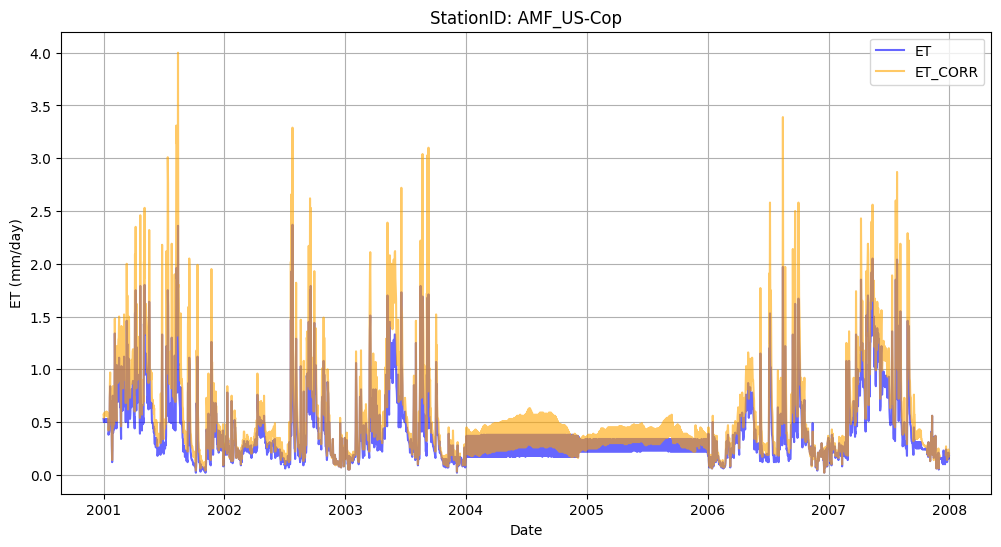

In [41]:
# selecet random StationID and plot ET and ET_Corr
import matplotlib.pyplot as plt
import numpy as np
import random
random_station = random.choice(data['StationID'].cat.categories)
station_data = data[data['StationID'] == random_station].sort_values(by='Date')
plt.figure(figsize=(12, 6))
plt.plot(station_data['Date'], station_data['ET'], label='ET', color='blue', alpha=0.6)
plt.plot(station_data['Date'], station_data['ET_CORR'], label='ET_CORR', color='orange', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('ET (mm/day)')
plt.title(f'StationID: {random_station}')
plt.legend()
plt.grid()
plt.show()
